In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('wordnet')
tknzr = TweetTokenizer()
import re
import nltk
import sys
nltk.download('punkt')
!{sys.executable} -m pip install emoji
import emoji


%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/perry.oconnor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/perry.oconnor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
train = pd.read_csv("../data/raw/train.csv", encoding='utf8')
test = pd.read_csv("../data/raw/test.csv", encoding='utf8')
sub_sample = pd.read_csv("../data/raw/submission_set.csv", encoding='utf8')

train_disaster = pd.read_csv("../data/raw/train.csv", encoding='utf8')
train_disaster.drop(train_disaster[(train_disaster.disaster != 1)].index, axis=0,inplace=True)

train_nondisaster = pd.read_csv("../data/raw/train.csv", encoding='utf8')
train_nondisaster.drop(train_nondisaster[(train_nondisaster.disaster != 0)].index, axis=0,inplace=True)

## Pre-processing steps
* Throw away special characters, punctuations, digits, HTML tags, quote, additional spaces, URLs and replies to users (@usernames) - They often appear in tweets, but do not contain any information for identifying topic.
* Capitalization, case folding - convert all words to lower case
* Correct spelling mistakes
* Nested words - filtering words by length.
* Stopwords removal - stopwords (such as prepositions, articles, a, is, the, with etc) have a high frequency of occurrence in the tweets. They do not carry much meaning and are not typically related to topic classification. Classifiers on average are more accurate without stopwords.
* Stemming- In this process we remove the postfix from each words like “ing”,“tion” etc
* Tokenization- This process is very important for Data preprocessing as it includes several sub steps like “Removal of Extra spaces”, “Emoticons (,) used replaced with their actual meaning like Happy, Sad by using Emoticon data set available on Internet”, “Abbreviations like OMG, WTF are replaced by their actual meanings”, “Pragmatics handling like hapyyyyyyy as happy, guddddd as good etc.”


In [81]:
# pre-processing features
import string
import emoji
import re

def getValueCounts(function,attribute):
    print("disaster")
    train_disaster1 = function(train_disaster)
    print(train_disaster1[attribute].value_counts())

    print("nondisaster")
    train_nondisaster1 = function(train_nondisaster)
    print(train_nondisaster1[attribute].value_counts())
    return

def doVisualization(non_disasters_num,disasters_num,label):
    non_disasters1 = [int(np.round(non_disasters_num/11200*100)), int(np.round((1 - non_disasters_num/11200)*100))]
    disasters1 = [int(np.round((disasters_num/2820)*100)), int(np.round((1 - disasters_num/2820)*100))]
    
    labels = ['contains '+label, 'no '+label]

    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters1, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters1, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing '+label,fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt

def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'',text)

# print(strip_emoji('hello🙄🤔'))

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_digits(text):
    for digit in string.digits:
        text = text.replace(digit, '')
    return text

def remove_mentions(text):
    word_list = text.split()
    for word in word_list:
        if word[0] == "@":
            text = text.replace(word,'')
    return text
# string = "@soundcloud can you recover"
# print(remove_mentions(string))

def remove_urls(text):
    word_list = text.split()
    for word in word_list:
        if "http" in word:
            text = text.replace(word,'')
    return text

def contains_proper_nouns(text):
    word_list = text.split()
    word_list2 = word_list[1:]
    for word in word_list2:
        is_proper_noun = re.match(r'^[A-Z]',word)
        if is_proper_noun:
            return True
        
# string = "hello this is a Test for Perry"
# print(num_proper_nouns(string))

def has_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    text2 = pattern.sub(r"\1\1",text)
    if text != text2:
        return True
    else:
        return False


In [4]:
# CLEAN TEXT functions
def clean_text(df):
    df_temp = df.copy()
    df_temp['clean_text'] = df_temp['text'].apply(lambda x: x.lower())
    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_punctuations)
    
    return df_temp


def clean_text2(df):
    df_temp = df.copy()
    df_temp['clean_text'] = df_temp['text'].apply(remove_mentions)
    df_temp['clean_text'] = df_temp['clean_text'].apply(lambda x: x.lower())
    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_mentions)
    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_punctuations)
    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_urls)
    
    return df_temp


# DATAFRAME TRANSFORMATION FUNCTIONS

def tweet_contains_punctuation(df):
    df_temp = df.copy()
    nmbr_of_punct_marks = df_temp['text'].apply(lambda x: len(set(x) & set(string.punctuation)))
    df_temp['has_punctuation'] = nmbr_of_punct_marks.astype(bool).astype(int)
    return df_temp

def tweet_contains_multi_sentence(df):
    df_temp = df.copy()
    df_temp['clean_text'] = df_temp['text'].apply(remove_urls)
    sentence_markers = [".","!","?"]
    nmbr_of_sentences = df_temp['clean_text'].apply(lambda x: len(set(x) & set(sentence_markers)))
    df_temp['has_multi_sentence'] = nmbr_of_sentences.astype(bool).astype(int)
    return df_temp
    
def tweet_contains_mention(df):
    df_temp = df.copy()
    nmbr_of_mentions = df_temp['text'].apply(lambda x: len(set(x) & set("@")))
    df_temp['has_mention'] = nmbr_of_mentions.astype(bool).astype(int)
    return df_temp

def tweet_contains_disaster_word(df):
    df_temp = df.copy()
    disaster_words = ["flood","hurricane","tornado","fire"]
    nmbr_of_disasters = df_temp['text'].apply(lambda x: len(set(x.split()) & set(disaster_words)))
    df_temp['has_disaster_word'] = nmbr_of_disasters.astype(bool).astype(int)
    return df_temp

def tweet_contains_disaster_word_clean(df):
    df_temp = df.copy()
    df_temp = clean_text(df_temp)
    disaster_words = ["flood","hurricane","tornado","fire","earthquake","cyclone"]
    nmbr_of_disasters = df_temp['clean_text'].apply(lambda x: len(set(x.split()) & set(disaster_words)))
    df_temp['has_disaster_word'] = nmbr_of_disasters.astype(bool).astype(int)
    return df_temp

def tweet_contains_numbers(df):
    df_temp = df.copy()
    nmbr_of_numbers = df_temp['text'].apply(lambda x: len(set(x) & set(string.digits)))
    df_temp['has_numbers'] = nmbr_of_numbers.astype(bool).astype(int)
    return df_temp

def tweet_contains_emoji(df):
    df_temp = df.copy()
    nmbr_of_emojis = df_temp['text'].apply(text_has_emoji)
    df_temp['has_emoji'] = nmbr_of_emojis.astype(bool).astype(int)
    return df_temp

def tweet_contains_proper_noun(df):
    df_temp = df.copy()
    df_temp['clean_text'] = df_temp['text'].apply(remove_mentions)
    proper_nouns = df_temp['clean_text'].apply(contains_proper_nouns)
    df_temp['has_proper_nouns'] = proper_nouns.astype(bool).astype(int)
    return df_temp
    
def tweet_has_lengthened_words(df):
    df_temp = df.copy()
    df_temp['clean_text'] = df_temp['text'].apply(remove_punctuations)
    df_temp['clean_text'] = df_temp['clean_text'].apply(lambda x: x.lower())

    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_digits)
    df_temp['clean_text'] = df_temp['clean_text'].apply(remove_mentions)

    has_lengthened_words = df_temp['clean_text'].apply(has_lengthening)
    df_temp['has_lengthened_words'] = has_lengthened_words.astype(bool).astype(int)
    return df_temp

def tweet_contains_url(df):
    df_temp = df.copy()
    nmbr_of_urls = df_temp['text'].apply(lambda x: len(re.findall("http",x)))
    df_temp['has_url'] = nmbr_of_urls.astype(bool).astype(int)
    return df_temp



#  DATA EXPLORATION

## LENGTHENING

alltweets
0    13265
1      755
Name: has_lengthened_words, dtype: int64
disaster
0    2636
1     184
Name: has_lengthened_words, dtype: int64
nondisaster
0    10629
1      571
Name: has_lengthened_words, dtype: int64


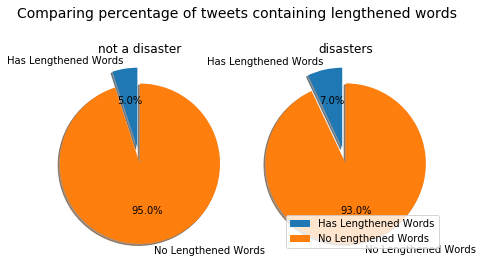

In [34]:
# train_lengthening = tweet_has_lengthened_words(train)
# print(train_lengthening['has_lengthened_words'].value_counts())


# train_lengthening.loc[train_lengthening['has_lengthened_words']==1]

train_lengthening = tweet_has_lengthened_words(train)
print("alltweets")
print(train_lengthening['has_lengthened_words'].value_counts())
# train_lengthening.to_json("../jsons/train_has_lengthened_words.json")

def lengthVis():
    print("disaster")
    train_lengthening_disaster = tweet_has_lengthened_words(train_disaster)
    print(train_lengthening_disaster['has_lengthened_words'].value_counts())
    
    print("nondisaster")
    train_lengthening_nondisaster = tweet_has_lengthened_words(train_nondisaster)
    print(train_lengthening_nondisaster['has_lengthened_words'].value_counts())

    non_disasters_length = [int(np.round(571/11200*100)), int(np.round((1 - 571/11200)*100))]
    disasters_length = [int(np.round((184/2820)*100)), int(np.round((1 - 184/2820)*100))]

    labels = ['Has Lengthened Words', 'No Lengthened Words']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_length, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_length, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing lengthened words',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
figlength,plotlength = lengthVis()
plotlength.show()

# figlength.savefig('../charts/lengthened_words.png')

## HAS URLS

0    7875
1    6145
Name: has_url, dtype: int64
disaster
0    1699
1    1121
Name: has_url, dtype: int64
nondisaster
0    6176
1    5024
Name: has_url, dtype: int64


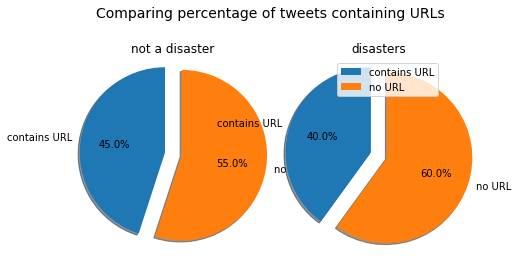

In [32]:
train_urls = tweet_contains_url(train)
train_urls.head()
print(train_urls['has_url'].value_counts())
# train_urls.to_json("../jsons/train_has_url.json")

def urlVis():
    print("disaster")
    train_urls_disaster = tweet_contains_url(train_disaster)
    print(train_urls_disaster['has_url'].value_counts())

    print("nondisaster")
    train_urls_nondisaster = tweet_contains_url(train_nondisaster)
    print(train_urls_nondisaster['has_url'].value_counts())

    non_disasters_url = [int(np.round(5024/11200*100)), int(np.round((1 - 5024/11200)*100))]
    disasters_url = [int(np.round((1121/2820)*100)), int(np.round((1 - 1121/2820)*100))]

    labels = ['contains URL', 'no URL']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_url, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_url, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing URLs',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
figurl,ploturl = urlVis()
ploturl.show()

# figurl.savefig('../charts/urls.png')

## EMOJIS

0    13664
1      356
Name: has_emoji, dtype: int64
disaster
0    2820
Name: has_emoji, dtype: int64
nondisaster
0    10844
1      356
Name: has_emoji, dtype: int64


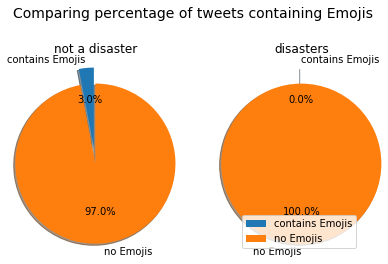

In [38]:
train_emoji = tweet_contains_emoji(train)
train_emoji.head()
print(train_emoji['has_emoji'].value_counts())
# train_emoji.to_json("../jsons/train_has_emoji.json")


def emojiVis():
    print("disaster")
    train_emoji_disaster = tweet_contains_emoji(train_disaster)
    print(train_emoji_disaster['has_emoji'].value_counts())

    print("nondisaster")
    train_emoji_nondisaster = tweet_contains_emoji(train_nondisaster)
    print(train_emoji_nondisaster['has_emoji'].value_counts())

    non_disasters_emoji = [int(np.round(356/11200*100)), int(np.round((1 - 356/11200)*100))]
    disasters_emoji = [int(np.round((0/2820)*100)), int(np.round((1 - 0/2820)*100))]

    labels = ['contains Emojis', 'no Emojis']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_emoji, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_emoji, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing Emojis',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
fig_emoji,plot_emoji = emojiVis()
plot_emoji.show()

# fig_emoji.savefig('../charts/emojis.png')

## DISASTER WORDS

0    11593
1     2427
Name: has_disaster_word, dtype: int64
disaster
1    2262
0     558
Name: has_disaster_word, dtype: int64
nondisaster
0    11035
1      165
Name: has_disaster_word, dtype: int64


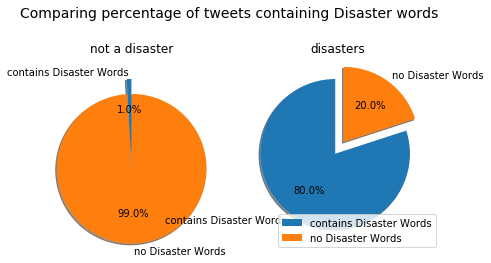

In [43]:
train_diaster_words = tweet_contains_disaster_word_clean(train)
print(train_diaster_words['has_disaster_word'].value_counts())
# train_emoji.to_json("../jsons/train_has_disaster_word.json")


def disasterWordVis():
    print("disaster")
    train_diaster_words_disaster = tweet_contains_disaster_word_clean(train_disaster)
    print(train_diaster_words_disaster['has_disaster_word'].value_counts())

    print("nondisaster")
    train_diaster_words_nondisaster = tweet_contains_disaster_word_clean(train_nondisaster)
    print(train_diaster_words_nondisaster['has_disaster_word'].value_counts())

    non_disasters_disaster_words = [int(np.round(165/11200*100)), int(np.round((1 - 165/11200)*100))]
    disasters_disaster_words = [int(np.round((2262/2820)*100)), int(np.round((1 - 2262/2820)*100))]

    labels = ['contains Disaster Words', 'no Disaster Words']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_disaster_words, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_disaster_words, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing Disaster words',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
fig_dwords,plot_dwords = disasterWordVis()
plot_dwords.show()

# fig_dwords.savefig('../charts/disaster_words.png')

## PUNCTUATION

1    12760
0     1260
Name: has_punctuation, dtype: int64
disaster
1    2330
0     490
Name: has_punctuation, dtype: int64
nondisaster
1    10430
0      770
Name: has_punctuation, dtype: int64


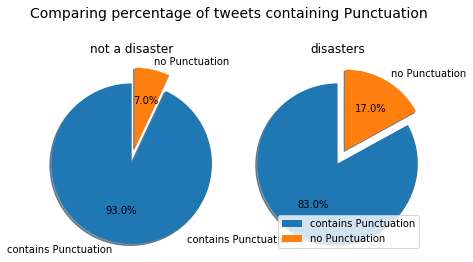

In [48]:
# def tweet_contains_punctuation(df):
#     df_temp = df.copy()
#     nmbr_of_punct_marks = df_temp['text'].apply(lambda x: len(set(x) & set(string.punctuation)))
#     df_temp['has_punctuation'] = nmbr_of_punct_marks.astype(bool).astype(int)
#     return df_temp

train_punctuation = tweet_contains_punctuation(train)
print(train_punctuation['has_punctuation'].value_counts())

train_punctuation.to_json("../jsons/train_has_punctuation.json")


print("disaster")
train_disaster_punctuation = tweet_contains_punctuation(train_disaster)
print(train_disaster_punctuation['has_punctuation'].value_counts())

print("nondisaster")
train_nondisaster_punctuation = tweet_contains_punctuation(train_nondisaster)
print(train_nondisaster_punctuation['has_punctuation'].value_counts())

def punctuationVis():
    non_disasters_punctuation = [int(np.round(10430/11200*100)), int(np.round((1 - 10430/11200)*100))]
    disasters_punctuation = [int(np.round((2330/2820)*100)), int(np.round((1 - 2330/2820)*100))]

    labels = ['contains Punctuation', 'no Punctuation']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_punctuation, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_punctuation, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing Punctuation',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
fig_punc,plot_punc = punctuationVis()
plot_punc.show()

# fig_punc.savefig('../charts/punctuation.png')

# 2820 disasters
# 2330 of disasters has punctuation
# 10430 of non-disaster tweets has punctuation
# 14020 total tweets



## MENTIONS

0    11566
1     2454
Name: has_mention, dtype: int64
disaster
0    2808
1      12
Name: has_mention, dtype: int64
nondisaster
0    8758
1    2442
Name: has_mention, dtype: int64


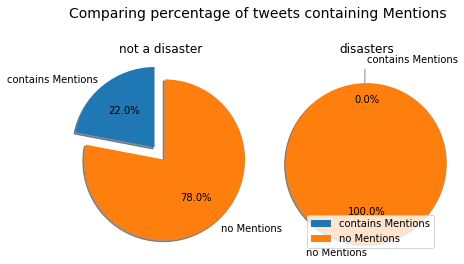

In [53]:
train_mentions = tweet_contains_mention(train)
print(train_mentions['has_mention'].value_counts())

# train_mentions.to_json("../jsons/train_has_mention.json")


print("disaster")
train_disaster_mention = tweet_contains_mention(train_disaster)
print(train_disaster_mention['has_mention'].value_counts())

print("nondisaster")
train_nondisaster_mention = tweet_contains_mention(train_nondisaster)
print(train_nondisaster_mention['has_mention'].value_counts())

def mentionsVis():
    non_disasters_mentions = [int(np.round(2442/11200*100)), int(np.round((1 - 2442/11200)*100))]
    disasters_mentions = [int(np.round((12/2820)*100)), int(np.round((1 - 12/2820)*100))]

    labels = ['contains Mentions', 'no Mentions']
    explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'no punctuation')
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig1.subplots_adjust(wspace = 0.6,top = 0.8 )
    ax1.pie(non_disasters_mentions, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('not a disaster')

    ax2.pie(disasters_mentions, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax2.axis('equal') 
    ax2.set_title('disasters')
    plt.suptitle('Comparing percentage of tweets containing Mentions',fontsize=14,fontweight=4)

    plt.legend(loc='best')
    
    return fig1,plt
    
fig_mention,plot_mention = mentionsVis()
plot_mention.show()

# fig_mention.savefig('../charts/mentions.png')


## NUMBERS

0    7154
1    6866
Name: has_numbers, dtype: int64
disaster
0    1663
1    1157
Name: has_numbers, dtype: int64
nondisaster
1    5709
0    5491
Name: has_numbers, dtype: int64


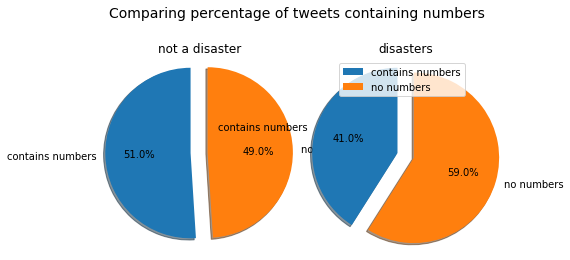

In [68]:
# def tweet_contains_numbers(df):
#     df_temp = df.copy()
#     nmbr_of_numbers = df_temp['text'].apply(lambda x: len(set(x) & set(string.digits)))
#     df_temp['has_numbers'] = nmbr_of_numbers.astype(bool).astype(int)
#     return df_temp

train_numbers = tweet_contains_numbers(train)
print(train_numbers['has_numbers'].value_counts())

# train_numbers.to_json("../jsons/train_has_numbers.json")

getValueCounts(tweet_contains_numbers,'has_numbers')

# doVisualization(non_disaster_num,disaster_num,'Mentions')
fig_numbers,plot_numbers = doVisualization(5709,1157,'numbers')

plot_numbers.show()
# fig_numbers.savefig('../charts/numbers.png')


# MODELING

In [70]:
# viz by disaster type
import sys
!{sys.executable} -m pip install -U textblob
!{sys.executable} -m pip install -U pyspellchecker

Requirement already up-to-date: textblob in /usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages (0.15.3)
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: pyspellchecker in /usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages (0.5.4)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [97]:
#Data Preprocessing and Feature Engineering

from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from spellchecker import SpellChecker

## Ryans work

In [76]:
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


# this is the method that is input into the pipeline - where most of the work is done
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [77]:
# testing methods
train['text_processed'] = train['text'].apply(form_sentence)
train['text_processed'] = train['text_processed'].apply(no_user_alpha)
train['text_processed'] = train['text_processed'].apply(normalization)

In [91]:
# here is the modeling pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [92]:
msg_train, msg_test, label_train, label_test = train_test_split(train['text'], train['disaster'], test_size=0.2)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2434
           1       0.65      1.00      0.78       370

    accuracy                           0.93      2804
   macro avg       0.82      0.96      0.87      2804
weighted avg       0.95      0.93      0.93      2804

[[2231  203]
 [   0  370]]
0.9276034236804565


In [ ]:
msg_train

## Perry WIP

In [128]:
from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english",ignore_stopwords=True)
stemmer = SnowballStemmer("english")

def stem_words(text):
    return " ".join([word if word==stemmer.stem(word) else stemmer.stem(word) for word in text.split()])

def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1",text)

# this is the method that is input into the pipeline - where most of the work is done
def text_process2(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """

    # Strip URLs
    nopunc = remove_urls(mess)
    
    # Stem words
    nopunc = stem_words(nopunc)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in nopunc if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]



def text_process3(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Strip out emojis
    nopunc = strip_emoji(mess)

    # Strip URLs
    nopunc = remove_urls(nopunc)
    
    nopunc = remove_digits(nopunc)
#     #reduce lengthening
#     nopunc = reduce_lengthening(nopunc)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in nopunc if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]



In [160]:
# here is the modeling pipeline
pipeline2 = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process2)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


# # here is the modeling pipeline
# pipeline2 = Pipeline([
#     ('bow',CountVectorizer(analyzer=text_process2)),  # strings to token integer counts
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', ComplementNB()),  # train on TF-IDF vectors w/ ComplementNB classifier
# ])



In [161]:
msg_train2, msg_test2, label_train2, label_test2 = train_test_split(train['text'], train['disaster'], test_size=0.2)
pipeline2.fit(msg_train2,label_train2)
predictions2 = pipeline2.predict(msg_test2)
print(classification_report(predictions2,label_test2))
print(confusion_matrix(predictions2,label_test2))
print(accuracy_score(predictions2,label_test2))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2457
           1       0.64      1.00      0.78       347

    accuracy                           0.93      2804
   macro avg       0.82      0.96      0.87      2804
weighted avg       0.96      0.93      0.94      2804

[[2263  194]
 [   1  346]]
0.9304564907275321


# WIP area

In [162]:
print(predictions2)

[0 0 0 ... 0 0 0]


In [163]:
print(msg_test2)
print(label_test2)

8133     for an extra month I was literally traumatised...
4090     Karl-Anthony Towns average 11.7 points, 7.4 re...
10031                  I'll kiss the ugly parts of you too
12695    We're getting a little wet today. Ex-cyclone D...
8763     Google Alert: Emergency units simulate a chemi...
                               ...                        
6741     #NoteToSelf...\n...There's rhyme and reason\nf...
5799     Looks like a mudslide and tastes like rubber o...
2280     #Win an #IttyBitty bundle to celebrate their a...
3974     first time is street is starting to flood and ...
686      and my sorry ass dropped straIghT INTO HELL ht...
Name: text, Length: 2804, dtype: object
8133     0
4090     0
10031    0
12695    1
8763     0
        ..
6741     0
5799     0
2280     0
3974     1
686      0
Name: disaster, Length: 2804, dtype: int64


In [178]:
print(msg_test2.index[1])

4090


In [202]:
# print(predictions2[10])
# print(type(predictions2))
# print(type(msg_test2))
# msg_test2_numpy = msg_test2.to_numpy()
# print(msg_test2_numpy)
# print(msg_test2)
# msg_test2_list = msg_test2.tolist()
# print(msg_test2_list[0])
# label_test2_list = label_test2.tolist()
# print(type(label_test2))
# print(label_test2_list[0])
# # print(msg_test2[10][10])
# # print(label_test2[10])
# print(len(label_test2_list))
# print(len(msg_test2_list))
# print(len(predictions2))

print(msg_test2.index[0]+10001)
print(msg_test2)

18134
8133     for an extra month I was literally traumatised...
4090     Karl-Anthony Towns average 11.7 points, 7.4 re...
10031                  I'll kiss the ugly parts of you too
12695    We're getting a little wet today. Ex-cyclone D...
8763     Google Alert: Emergency units simulate a chemi...
                               ...                        
6741     #NoteToSelf...\n...There's rhyme and reason\nf...
5799     Looks like a mudslide and tastes like rubber o...
2280     #Win an #IttyBitty bundle to celebrate their a...
3974     first time is street is starting to flood and ...
686      and my sorry ass dropped straIghT INTO HELL ht...
Name: text, Length: 2804, dtype: object


In [203]:

def find_false_positives(predictions_array,message_series,label_series):
    message_array = message_series.tolist()
    label_array = label_series.tolist()
    fp_indices = []
    for i in range(0,len(predictions_array)):
        if predictions_array[i] == 1 and label_array[i] == 0:
            fp_indices.append(i)
    fp_tweets = []
    fp_tweet_ids = []
    fp_labels = []
    fp_predictions = []
    for index in fp_indices:
        fp_tweets.append(message_array[index])
        fp_tweet_ids.append(message_series.index[index]+10001)
        fp_labels.append(label_array[index])
        fp_predictions.append(predictions_array[index])
    return fp_indices,fp_tweets, fp_tweet_ids,fp_labels,fp_predictions
        
fp_indices1,fp_tweets1,fp_tweet_ids1,fp_labels1,fp_predictions1 = find_false_positives(predictions2, msg_test2, label_test2)
# print(fp_indices1)
# print(len(fp_tweets1))
# print(len(fp_tweet_ids1))

for (tweet,tweet_id) in zip(fp_tweets1,fp_tweet_ids1):
    print(str(tweet_id)+": "+str(tweet))
# print(fp_tweets1)
# print(len(fp_indices1))
# print(len(fp_tweets1))


22561: A powerful storm will impact the area, Wed afternoon into Thurs. Strong wind and rain expected.  #RIwx https://t.co/yb0wwQAXuU


In [204]:
def find_false_negatives(predictions_array,message_series,label_series):
    message_array = message_series.tolist()
    label_array = label_series.tolist()
    fn_indices = []
    for i in range(0,len(predictions_array)):
        if predictions_array[i] == 0 and label_array[i] == 1:
            fn_indices.append(i)
    fn_tweets = []
    fn_tweet_ids = []
    fn_labels = []
    fn_predictions = []
    for index in fn_indices:
        fn_tweets.append(message_array[index])
        fn_tweet_ids.append(message_series.index[index]+10001)
        fn_labels.append(label_array[index])
        fn_predictions.append(predictions_array[index])
    return fn_indices,fn_tweets,fn_tweet_ids, fn_labels, fn_predictions
     
fn_indices1,fn_tweets1,fn_tweet_ids1,fn_labels1,fn_predictions1 = find_false_negatives(predictions2, msg_test2, label_test2)
print(fn_indices1)

for (tweet,tweet_id) in zip(fn_tweets1,fn_tweet_ids1):
    print(str(tweet_id)+": "+str(tweet))
# print(fp_tweets1)
print(len(fn_indices1))
print(len(fn_tweets1))

[6, 33, 51, 52, 102, 125, 160, 161, 164, 174, 196, 197, 213, 229, 230, 233, 242, 281, 284, 290, 308, 311, 312, 313, 335, 337, 352, 361, 405, 407, 416, 424, 437, 443, 459, 461, 484, 485, 524, 535, 547, 595, 609, 610, 618, 627, 649, 667, 671, 698, 703, 705, 725, 757, 788, 795, 802, 836, 837, 870, 882, 892, 905, 923, 932, 973, 998, 1048, 1057, 1087, 1104, 1125, 1143, 1160, 1164, 1169, 1224, 1236, 1242, 1247, 1281, 1283, 1301, 1306, 1340, 1346, 1355, 1363, 1391, 1409, 1444, 1445, 1471, 1499, 1505, 1514, 1547, 1575, 1580, 1583, 1591, 1595, 1605, 1611, 1614, 1642, 1649, 1651, 1652, 1681, 1702, 1713, 1715, 1750, 1759, 1771, 1772, 1775, 1808, 1816, 1818, 1857, 1862, 1873, 1897, 1901, 1907, 1913, 1920, 1923, 1928, 1943, 1944, 1958, 1981, 1991, 1992, 2021, 2025, 2033, 2062, 2063, 2081, 2082, 2091, 2095, 2096, 2103, 2136, 2150, 2181, 2220, 2221, 2232, 2234, 2239, 2256, 2274, 2281, 2286, 2302, 2318, 2327, 2382, 2391, 2403, 2414, 2416, 2420, 2450, 2483, 2488, 2512, 2514, 2522, 2537, 2542, 2551, 255

In [205]:
fp_d = {'tweet_id': fp_tweet_ids1,'tweet_text': fp_tweets1,'tweet_label': fp_labels1, 'tweet_prediction': fp_predictions1}
fp_df = pd.DataFrame(data=fp_d)
print(fp_df.dtypes)
fp_df.head()

tweet_id             int64
tweet_text          object
tweet_label          int64
tweet_prediction     int64
dtype: object


,tweet_id,tweet_text,tweet_label,tweet_prediction
0,22561,"A powerful storm will impact the area, Wed aft...",0,1


In [206]:
fn_d = {'tweet_id': fn_tweet_ids1,'tweet_text': fn_tweets1, 'tweet_label': fn_labels1, 'tweet_prediction': fn_predictions1 }
fn_df = pd.DataFrame(data=fn_d)
print(fn_df.dtypes)
fn_df.head()

tweet_id             int64
tweet_text          object
tweet_label          int64
tweet_prediction     int64
dtype: object


,tweet_id,tweet_text,tweet_label,tweet_prediction
0,20174,Would explain why i smell smoke outside... htt...,1,0
1,12940,#PeakMediaDebbie has been reached https://t.co...,1,0
2,13026,The picture of the poor cockatoo caught in cyc...,1,0
3,20895,watching shane s new video scared as heck and...,1,0
4,18843,Ex Tropical cyclone Debbie on my door step rn ...,1,0


In [208]:
def create_fp_df(predictions_array, message_series, label_series):
    message_array = message_series.tolist()
    label_array = label_series.tolist()
    fp_indices = []
    for i in range(0,len(predictions_array)):
        if predictions_array[i] == 1 and label_array[i] == 0:
            fp_indices.append(i)
    fp_tweets = []
    fp_tweet_ids = []
    fp_labels = []
    fp_predictions = []
    for index in fp_indices:
        fp_tweets.append(message_array[index])
        fp_tweet_ids.append(message_series.index[index]+10001)
        fp_labels.append(label_array[index])
        fp_predictions.append(predictions_array[index])
#     return fp_indices,fp_tweets, fp_tweet_ids,fp_labels,fp_predictions

    fp_d = {'tweet_id': fp_tweet_ids,'tweet_text': fp_tweets,'actual_label': fp_labels, 'prediction_label': fp_predictions}
    fp_df = pd.DataFrame(data=fp_d)
    return fp_df


false_pos_df = create_fp_df(predictions2, msg_test2, label_test2)
false_pos_df.head()

,tweet_id,tweet_text,actual_label,prediction_label
0,22561,"A powerful storm will impact the area, Wed aft...",0,1


In [211]:
def create_fn_df(predictions_array,message_series,label_series):
    message_array = message_series.tolist()
    label_array = label_series.tolist()
    fn_indices = []
    for i in range(0,len(predictions_array)):
        if predictions_array[i] == 0 and label_array[i] == 1:
            fn_indices.append(i)
    fn_tweets = []
    fn_tweet_ids = []
    fn_labels = []
    fn_predictions = []
    for index in fn_indices:
        fn_tweets.append(message_array[index])
        fn_tweet_ids.append(message_series.index[index]+10001)
        fn_labels.append(label_array[index])
        fn_predictions.append(predictions_array[index])
#     return fn_indices,fn_tweets,fn_tweet_ids, fn_labels, fn_predictions
    fn_d = {'tweet_id': fn_tweet_ids,'tweet_text': fn_tweets, 'actual_label': fn_labels, 'prediction_label': fn_predictions }
    fn_df = pd.DataFrame(data=fn_d)
    return fn_df

false_neg_df = create_fn_df(predictions2,msg_test2,label_test2)
false_neg_df.head()

,tweet_id,tweet_text,actual_label,prediction_label
0,20174,Would explain why i smell smoke outside... htt...,1,0
1,12940,#PeakMediaDebbie has been reached https://t.co...,1,0
2,13026,The picture of the poor cockatoo caught in cyc...,1,0
3,20895,watching shane s new video scared as heck and...,1,0
4,18843,Ex Tropical cyclone Debbie on my door step rn ...,1,0


In [213]:
# False Positives & negatives
false_pos_df.to_json("../wrong-classifications/multinomialNB/false_positives1.json")
false_neg_df.to_json("../wrong-classifications/multinomialNB/false_negatives1.json")
# train_lengthening.to_json("../jsons/train_has_lengthened_words.json")


In [214]:
### more pipeline work with complement NB
# here is the modeling pipeline
pipeline3 = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process2)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', ComplementNB()),  # train on TF-IDF vectors w/ ComplementNB classifier
])

msg_train3, msg_test3, label_train3, label_test3 = train_test_split(train['text'], train['disaster'], test_size=0.2)
pipeline3.fit(msg_train3,label_train3)
predictions3 = pipeline3.predict(msg_test3)
print(classification_report(predictions3,label_test3))
print(confusion_matrix(predictions3,label_test3))
print(accuracy_score(predictions3,label_test3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2230
           1       0.88      0.88      0.88       574

    accuracy                           0.95      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.95      0.95      0.95      2804

[[2158   72]
 [  70  504]]
0.949358059914408


In [216]:
false_pos_df1 = create_fp_df(predictions3, msg_test3, label_test3)
false_pos_df1.head()

false_neg_df1 = create_fn_df(predictions3,msg_test3,label_test3)
false_neg_df1.head()

,tweet_id,tweet_text,actual_label,prediction_label
0,17738,great ending CourtTheShark Doc0312 https://t...,1,0
1,14704,When you can't reach surface anymore you just ...,1,0
2,17672,..we said that here..and have you noticed most...,1,0
3,14648,Me: was that an earthquake? My sister: idk i t...,1,0
4,12191,So scary. My aunts and uncle had to go to my m...,1,0


In [217]:
false_pos_df1.to_json("../wrong-classifications/complementNB/false_positives1.json")
false_neg_df1.to_json("../wrong-classifications/complementNB/false_negatives1.json")